From Cam Davidson's book, and Thomas Wiecki and Max Margenot's notebook: http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
from IPython.core.pylabtools import figsize
import pymc3 as pm
import theano.tensor as T

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# How MCMC works

**Algorithms to perform MCMC**

1. Start at current position.
2. Propose moving to a new position (investigate a pebble near you).
3. Accept/Reject the new position based on the position's adherence to the data and prior distributions (ask if the pebble likely came from the mountain).
4. If it is likely, you accept: Move to the new position. Return to Step 1.
5. if it is not likely, reject: Do not move to new position. Return to Step 1.
6. After a large number of iterations, return all accepted positions.
This way we move in the general direction towards the regions where the posterior distributions exist, and collect samples sparingly on the journey. Once we reach the posterior distribution, we can easily collect samples as they likely all belong to the posterior distribution.

If the current position of the MCMC algorithm is in an area of extremely low probability, which is often the case when the algorithm begins (typically at a random location in the space), the algorithm will move in positions that are likely not from the posterior but better than everything else nearby. Thus the first moves of the algorithm are not reflective of the posterior, which is why we tune the samples or create a burn-in period.

# Unsupervised Clustering using a Mixture Model

[116. 152. 179. 163. 107. 105. 118. 125. 103. 207.] ...
Shape of data: (300,)


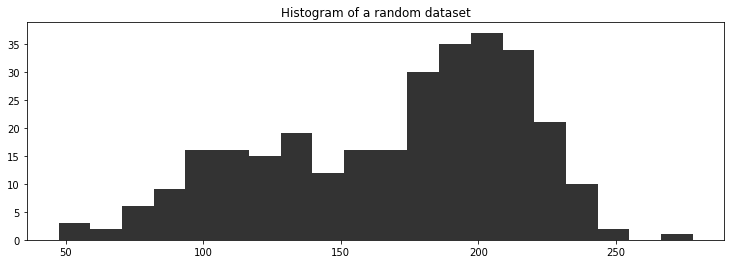

In [11]:
figsize(12.5, 4)
data = np.loadtxt("data_text.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of a random dataset")
plt.ylim([0, None]);
print(data[:10], "...")
print("Shape of data: "+str(data.shape))

**We'll use Pymc3 to group the data into 2 separate clusters:**
* In this case, assume each cluster follows a normal distribution
* We need to define the probability for each cluster to be 0 or 1
* Define the parameters of the distributions belonging to the std and mean of each cluser
* Use Deterministic to make note of each mean & std for each cluster and each datapoint
* Define the likelihood of the observed data given the suggested parameters

In [3]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)    # probability data assigned to cluster 1
    p2 = 1 - p1                   # probability data assigned to cluster 2
    p = T.stack([p1, p2])         # creates a vector that pymc3/theano can work with
    
    # after tracing, each of the 300 datapoints will have thousands of 'assignment' samples of either 0 or 1, 
    # based on the likelihood of them being 0 or 1. The trace['assignment'][:,8].mean() will give us the probability 
    # that the category/cluster for the 8th datapoint is equal to 1
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, size=data.shape[0])) #create 300 values with 0 or 1

In [4]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)    # prior distribution of the standard deviations for the two clusters
    centers = pm.Normal("centers",              # prior distribution of the  means for the two clusters
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])# Mean for each datapoint out of 300, depending on ass.
    sd_i = pm.Deterministic('sd_i', sds[assignment])            # Std for each datapoint out of 300, depending on ass.
    
    # likelihood of observed data, given mu and std of each datapoint
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data) 
    
print("Random assignments: ", assignment.tag.test_value[:4], "...")
print("Assigned center: ", center_i.tag.test_value[:4], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:4])

Random assignments:  [1 1 0 0] ...
Assigned center:  [190. 190. 120. 120.] ...
Assigned standard deviation:  [50. 50. 50. 50.]


In [5]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2], njobs=1)
    #trace = pm.sample(25000,  tune=20000, njobs=1) Using pm.sample() is usually faster & automatically assigns 
    #the right steps

C:\Users\adam\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds_interval__]
>>Metropolis: [p_interval__]
>ElemwiseCategorical: [assignment]
100%|███████████████████████████████████████████████████████████████████████████| 25500/25500 [03:51<00:00, 110.31it/s]
The number of effective samples is smaller than 10% for some parameters.


In [57]:
print(trace['assignment'].shape)
print(trace['p'].shape)
print(trace['sd_i'].shape)
print(trace['center_i'].shape)
print(trace['centers'].shape)
print(trace['sds'].shape)

(50000, 300)
(50000,)
(50000, 300)
(50000, 300)
(50000, 2)
(50000, 2)


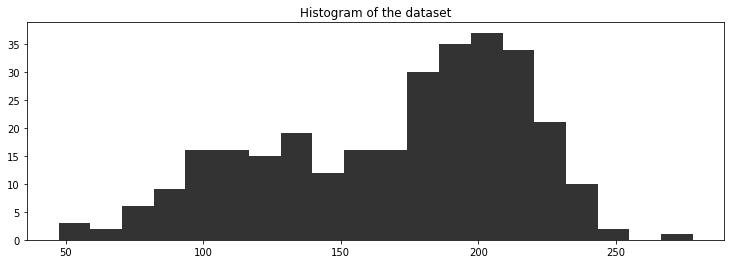

In [7]:
# The original dataset
figsize(12.5, 4)
data = np.loadtxt("data_text.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);

**Posterior Assignment/Cluster for each datapoint**

In [85]:
# the Trace samples 50,000 observations points for each datum (out of 300).
# In the eighth sample (where the datum is 103), the assignment/cluster has 0.0008 probability of == 1. 

print("Eighth datapoint: "+ str(data[8:9]))
print("Nineth datapoint: "+ str(data[9:10]))
print("\nEighth datapoint has probability of {} ".format(trace['assignment'][:,8].mean()),"of being == 1")
print("Nineth datapoint has probability of {} ".format(trace['assignment'][:,9].mean()),"of being == 1")

Eighth datapoint: [103.]
Nineth datapoint: [207.]

Eighth datapoint has probability of 0.00086  of being == 1
Nineth datapoint has probability of 0.98548  of being == 1


0.00086

In [119]:
print(trace['assignment'][:,9][:20])
print(trace['center_i'][:,9][:20])
print("\nDatum 9 (value 207) was assigned to cluster one 0.98% of the time out of 50,000 samples. We see that \
on the 20th sample it was assigned to 0, which is why the 20th mean is around 119.")
print("\nBut, these are the details of each datapoint. More important are the average mean and std for each \
datapoint which can be found in trace['centers'] and trace['sds']")

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
[198.61789768 198.61789768 199.36933446 199.36933446 199.21955004
 198.87313667 198.87313667 198.87313667 202.05165868 202.05165868
 202.05165868 202.05165868 199.22587706 199.22587706 199.22587706
 199.22587706 199.47496902 199.47496902 199.47496902 119.51595743]

Datum 9 (value 207) was assigned to cluster one 0.98% of the time out of 50,000 samples. We see that on the 20th sample it was assigned to 0, which is why the 20th mean is around 119.

But, these are the details of each datapoint. More important are the average mean and std for each datapoint which can be found in trace['centers'] and trace['sds']


**Posterior Probability of Assignment to cluster 0, that is, approximate % of datapoints assigend to cluster 0**

In [130]:
trace['p'].mean()

0.3781936319042299

**Posterior STD for each datapoint**

Eighth datapoint: [103.]
Nineth datapoint: [207.]


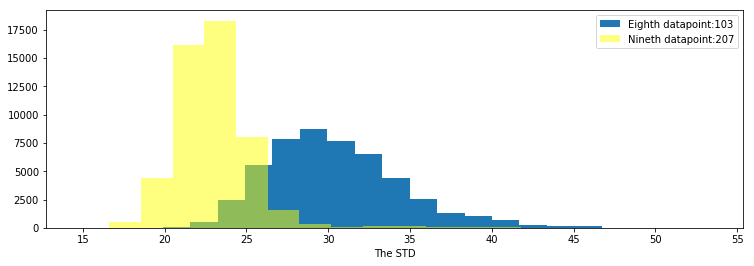

The posterior Std of the eighth datapoint is: 30.37409953603
The posterior Std of the nineth datapoint is: 23.00242386524316


In [132]:
print("Eighth datapoint: "+ str(data[8:9]))
print("Nineth datapoint: "+ str(data[9:10]))

plt.hist(trace['sd_i'][:,8], bins=20, label='Eighth datapoint:103')
plt.hist(trace['sd_i'][:,9], bins=20, color='yellow', alpha=0.5, label='Nineth datapoint:207')
plt.legend()
plt.xlabel("The STD")
plt.show()
print("The posterior Std of the eighth datapoint is: "+str(trace['sd_i'][:,8].mean()))
print("The posterior Std of the nineth datapoint is: "+str(trace['sd_i'][:,9].mean()))

BY visualizing the histogram of the original data, it makes sense that datapoints within the first cluster (arround mean 100) have a std that is broader/fatter than the datapoints within the second cluster (around mean 200).

Let's look into the:
**Posterior Mean for each datapoint:**

Eighth datapoint: [103.]
Nineth datapoint: [207.]


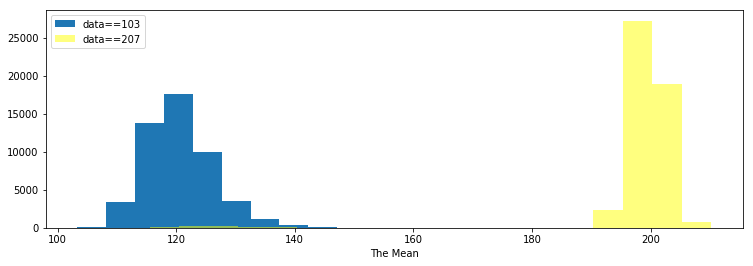

The posterior Mean of the eighth datapoint is: 120.57980470281876
The posterior Mean of the nineth datapoint is: 198.56197017393316


In [133]:
print("Eighth datapoint: "+ str(data[8:9]))
print("Nineth datapoint: "+ str(data[9:10]))

plt.hist(trace['center_i'][:,8], bins=20, label='data==103')
plt.hist(trace['center_i'][:,9], bins=20, color='yellow', alpha=0.5, label='data==207')
plt.legend()
plt.xlabel("The Mean")
plt.show()
print("The posterior Mean of the eighth datapoint is: "+str(trace['center_i'][:,8].mean()))
print("The posterior Mean of the nineth datapoint is: "+str(trace['center_i'][:,9].mean()))

**Posterior Mean for each cluster:**

In [135]:
print("Mean of all datapoints within cluster 0 (assignment ==0): "+str(trace['centers'][:,0].mean()))
print("Mean of all datapoints within cluster 1 (assignment ==1): "+str(trace['centers'][:,1].mean()))

Mean of all datapoints within cluster 0 (assignment ==0): 120.51133818172654
Mean of all datapoints within cluster 1 (assignment ==1): 199.64251923333472


**Posterior STD for each cluster:**

In [139]:
print("STD of all datapoints withint cluster 0 (assignment ==0): "+str(trace['sds'][:,0].mean()))
print("STD of all datapoints withint cluster 1 (assignment ==1): "+str(trace['sds'][:,1].mean()))

STD of all datapoints withint cluster 0 (assignment ==0): 30.37599923474751
STD of all datapoints withint cluster 1 (assignment ==1): 22.802753265517108


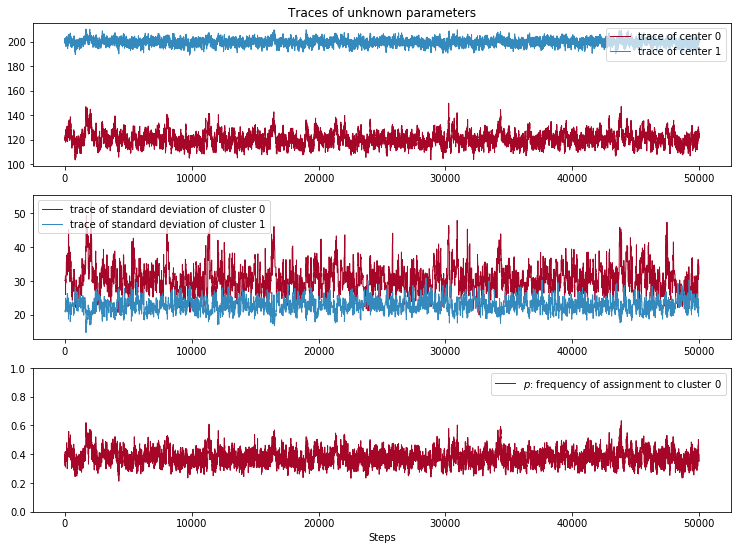

In [140]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

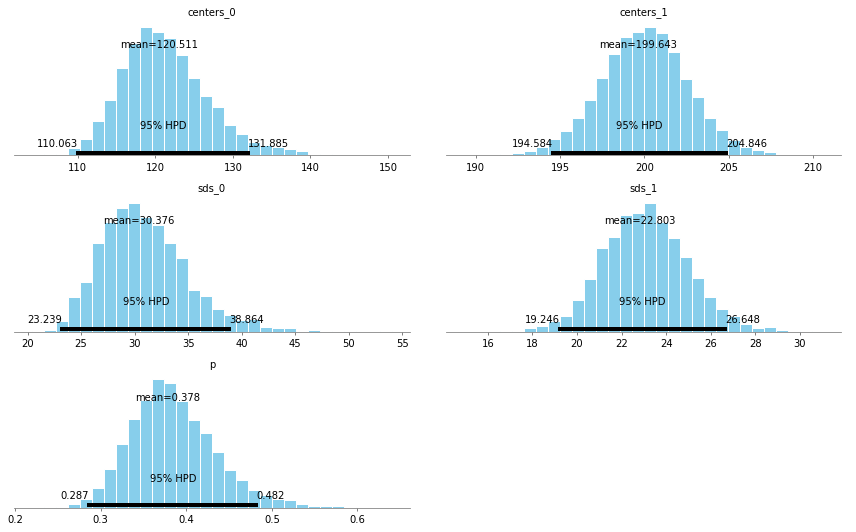

In [142]:
pm.plot_posterior(trace, varnames=['centers','sds','p'], color='#87ceeb')
plt.show()

To achieve further convergence, we will perform more MCMC steps. In the pseudo-code algorithm of MCMC above, the only position that matters is the current position (new positions are investigated near the current position), implicitly stored as part of the trace object. To continue where we left off, we pass the trace that we have already stored into the sample() function with the same step value. The values that we have already calculated will not be overwritten. This ensures that our sampling continues where it left off in the same way that it left off.

In [143]:
with model:
    trace = pm.sample(30000, step=[step1, step2], trace=trace, njobs=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds_interval__]
>>Metropolis: [p_interval__]
>ElemwiseCategorical: [assignment]
100%|███████████████████████████████████████████████████████████████████████████| 30500/30500 [04:57<00:00, 102.69it/s]
The number of effective samples is smaller than 10% for some parameters.


Plot the posterior distributions of the center and standard deviation variables like we did above before we ran the 2nd trace:

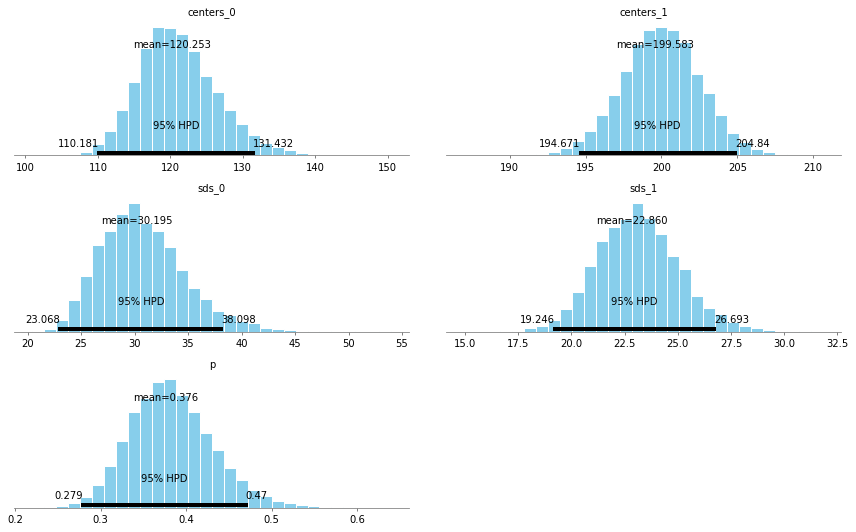

In [144]:
pm.plot_posterior(trace, varnames=['centers','sds','p'], color='#87ceeb')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026C50BEF8D0>,
      dtype=object)

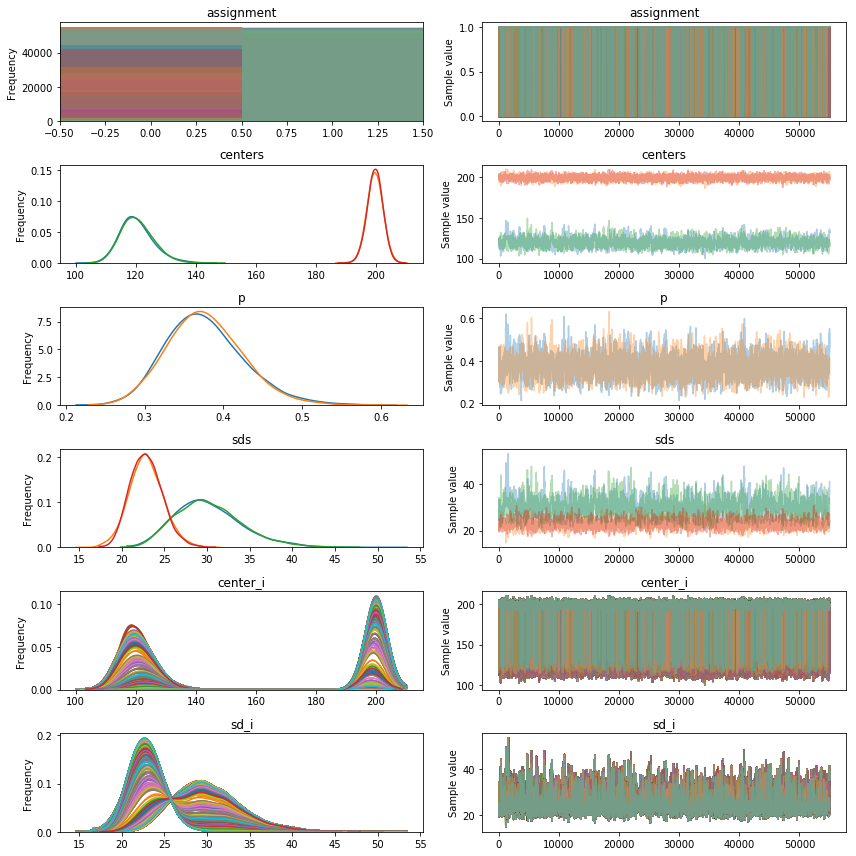

In [145]:
pm.traceplot(trace)

Notice the following characteristics:

* The traces converges, not to a single point, but to a distribution of possible points. This is convergence in an MCMC algorithm.
* Inference using the first few thousand points is a bad idea, as they are unrelated to the final distribution we are interested in. Thus is it a good idea to discard those samples before using the samples for inference. We call this period before converge the burn-in period. See center_trace below.
* The traces appear as a random "walk" around the space, that is, the paths exhibit correlation with previous positions. This is both good and bad. We will always have correlation between current positions and the previous positions. But too much autocorrelation means we are still exploring a wide space and have yet to reach the area of convergence, that is, the are of high posterior density.

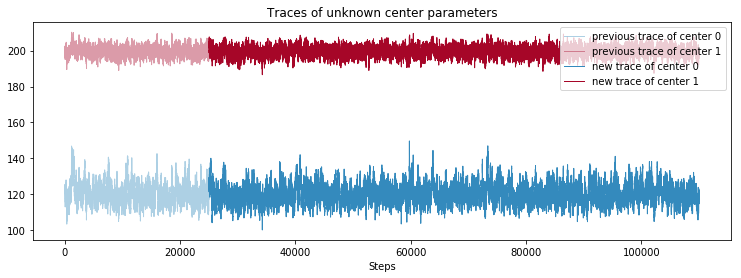

In [146]:
figsize(12.5, 4)
center_trace = trace["centers"][25000:]
prev_center_trace = trace["centers"][:25000]

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 110000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

# Prediction of clusters
**Does the datapoint value belong to cluster 0 or cluster 1?**
* A red square is an assignment to cluster 0, and a blue square is an assignment to cluster 1.

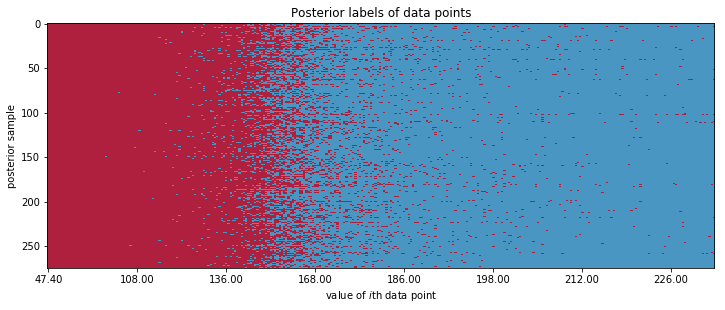

In [164]:
import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)

# trace['assignment'] has 110,000 rows as samples and 300 columns as datapoints for each value in the orginal data
# Below, slice the trace, so it extracts a sample every 400 jumps (110,000samples/400=275, also known as thining)
# with all the columns/datapoints. But first, sort the datapoints' index from smallest to largest values, 
# so the first sample extracted is for column/datapoint that has the lowest value (47.4) 
plt.imshow(trace["assignment"][::400, np.argsort(data)], 
           cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])  #slice the x.ticks to show different values 
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

In [155]:
print("For the first datapoint(47.40), all the 275 samples returned a red(cluster 0) dot.")
print("\nFirst datapoint value: "+str(data[np.argsort(data)][0]))
print("The 275 samples:")
trace["assignment"][::400, np.argsort(data)][:,0]

For the first datapoint(47.40), all the 275 samples returned a red(cluster 0) dot.

First datapoint value: 47.4
The 275 samples:


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [160]:
print("For the 110th datapoint, the 275 samples returned some 1's and some 0's.")
print("\n110th datapoint value: "+str(data[np.argsort(data)][110]))
print("The 275 samples:")
trace["assignment"][::400, np.argsort(data)][:,110]

For the 110th datapoint, the 275 samples returned some 1's and some 0's.

110th datapoint value: 160.0
The 275 samples:


array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1], dtype=int64)

Looking at the above plot, it appears that the most uncertainty is between 150 and 170 values. The above plot slightly misrepresents things, as the x-axis is not a true scale (it displays the value of the ith sorted data point.) A more accurate plot that represents the data without sorting is:

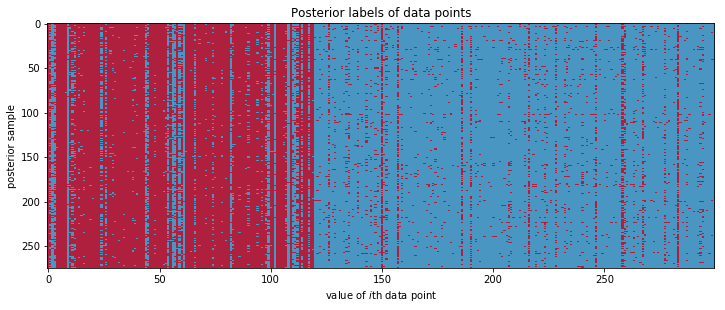

In [165]:
import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)

# trace['assignment'] has 110,000 rows as samples and 300 columns as datapoints for each value in the orginal data
# Below, slice the trace, so it extracts a sample every 400 jumps (110,000samples/400=275, also known as thining)
# with all the columns/datapoints. But first, sort the datapoints' index from smallest to largest values, 
# so the first sample extracted is for column/datapoint that has the lowest value (47.4) 
plt.imshow(trace["assignment"][::400], 
           cmap=plt.cmap, aspect=.4, alpha=.9)
# plt.xticks(np.arange(0, data.shape[0], 40),
#        ["%.2f" % s for s in np.sort(data)[::40]])  #slice the x.ticks to show different values 
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

An additional clear diagram is below, where we have estimated the frequency of each data point belonging to the labels 0 and 1.

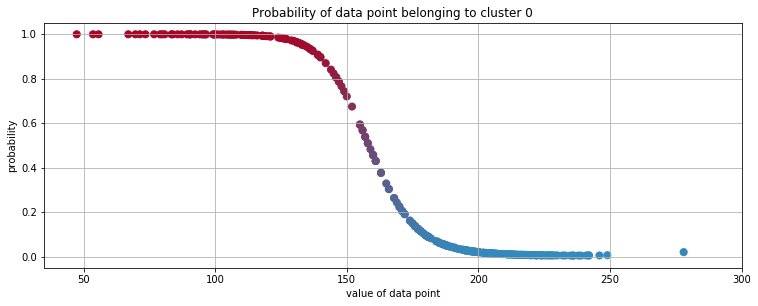

In [167]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]

# for datapoint(value=152), 1- (assign_trace[:,1].mean()) is 67%. 
# axis=0 refers to columns/datapoints as opposed to rows/samples; 
# thus, the plot below calculates mean for each of the 300 datapoints
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point")
plt.grid();

Above, we ilustrated the probability of a datapoint beloning to cluster 1 or 0, based on the posterior mean. However, to get a more accurate prediction, we should calculate the probability of clustering, based on the posterior mean and STD. See link below.

**For hypothetical datapoint value 165, what is the probability of it belonging to cluster 1?**

http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb#Returning-to-Clustering:-Prediction

In [252]:
norm_pdf = stats.norm.pdf

p_trace = trace["p"][25000:]            # drop the burn-in period  
prev_p_trace = trace["p"][:25000]      
std_trace = trace["sds"][25000:]        # drop the burn-in period
center_trace = trace["centers"][25000:] # drop the burn-in period

x = 165

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) < \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

print("Probability of belonging to cluster 1:", v.mean())

Probability of belonging to cluster 1: 0.8592117647058823


# Visualizing our posterior data

One way of visualizing is to take the posterior means and std's and create a random Normal Distribution, given that we used a Normal distribution in the likelihood

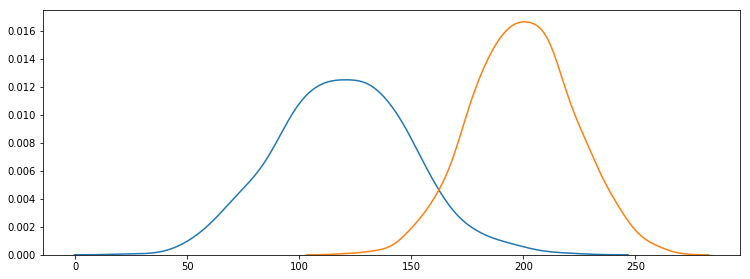

In [168]:
np.random.seed(seed=13)
sns.kdeplot(pm.Normal.dist(mu=trace['centers'][:,0].mean(),sd=trace['sds'][:,0].mean()).random(size=1000))
sns.kdeplot(pm.Normal.dist(mu=trace['centers'][:,1].mean(),sd=trace['sds'][:,1].mean()).random(size=1000))
plt.show()

**Another way to visualize is to overlay the Normal density functions, using the average "mean, std, and probability of assignment" distributions as the chosen parameters, with our observed data.**

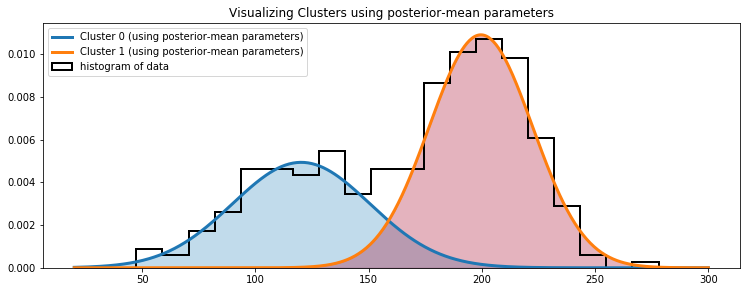

In [172]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()           # % of datapoints assigend to cluster 0 

plt.hist(data, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data")

#for y axis of orginal data to be proportional to y axis of posterior means, we need to multiply posterior 
# means of cluster 0 by the pdf of the posterior means of cluster 0
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)


y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

# Autocorrelation

When you have high autocorrelation the samples you've drawn don't accurately represent the posterior distribution and therefore don't provide as meaningful information for the solution to the problem. In other words, lower autocorrelation means higher efficiency in your chains and better estimates. 

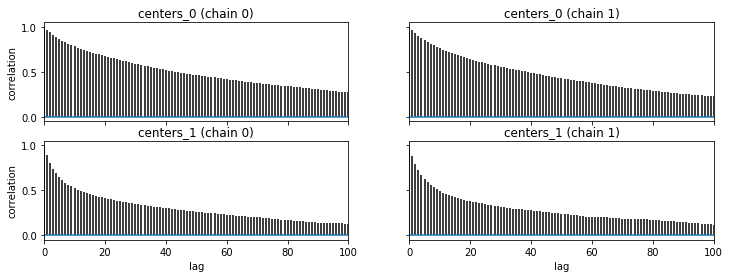

In [286]:
pm.plots.autocorrplot(trace=trace, varnames=["centers"])
plt.show()

If autocorrelation is high then N samples are not giving you N pieces of information about your distribution but fewer than that. The Effective Sample Size (ESS) is one measure of how much information you're really getting (and is a function of the autocorrelation parameter)

In [287]:
pm.summary(trace, varnames=['centers'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
centers__0,120.252971,5.465626,0.176969,110.181344,131.431790,808.678423,1.000187
centers__1,199.582995,2.588212,0.065010,194.670565,204.839732,1371.815502,1.000032


By thinning, the autocorrelation drops quicker.

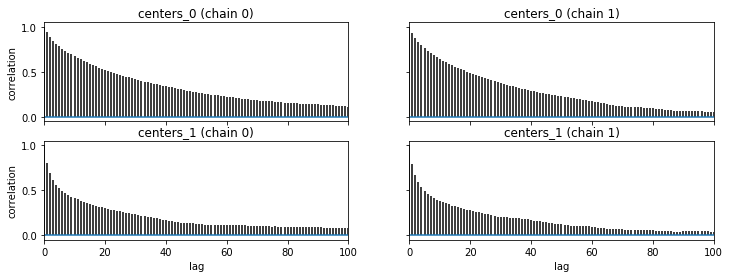

In [272]:
samtrace = trace[::2]
pm.plots.autocorrplot(trace=samtrace, varnames=["centers"])
plt.show()

# Useful tips for MCMC

* Intelligent starting values

It would be great to start the MCMC algorithm off near the posterior distribution, so that it will take little time to start sampling correctly. We can aid the algorithm by telling where we think the posterior distribution will be by specifying the testval parameter in the Stochastic variable creation. In many cases we can produce a reasonable guess for the parameter. For example, if we have data from a Normal distribution, and we wish to estimate the μ parameter, then a good starting value would be the mean of the data.

`mu = pm.Uniform( "mu", 0, 100, testval = data.mean() )`

**Priors**

If the priors are poorly chosen, the MCMC algorithm may not converge, or atleast have difficulty converging. Consider what may happen if the prior chosen does not even contain the true parameter: the prior assigns 0 probability to the unknown, hence the posterior will assign 0 probability as well. This can cause pathological results.

For this reason, it is best to carefully choose the priors. Often, lack of covergence or evidence of samples crowding to boundaries implies something is wrong with the chosen priors.